Mean Absolute Error (Coulomb Counting): 1.73%
Mean Absolute Error (Kalman Filter): 0.91%


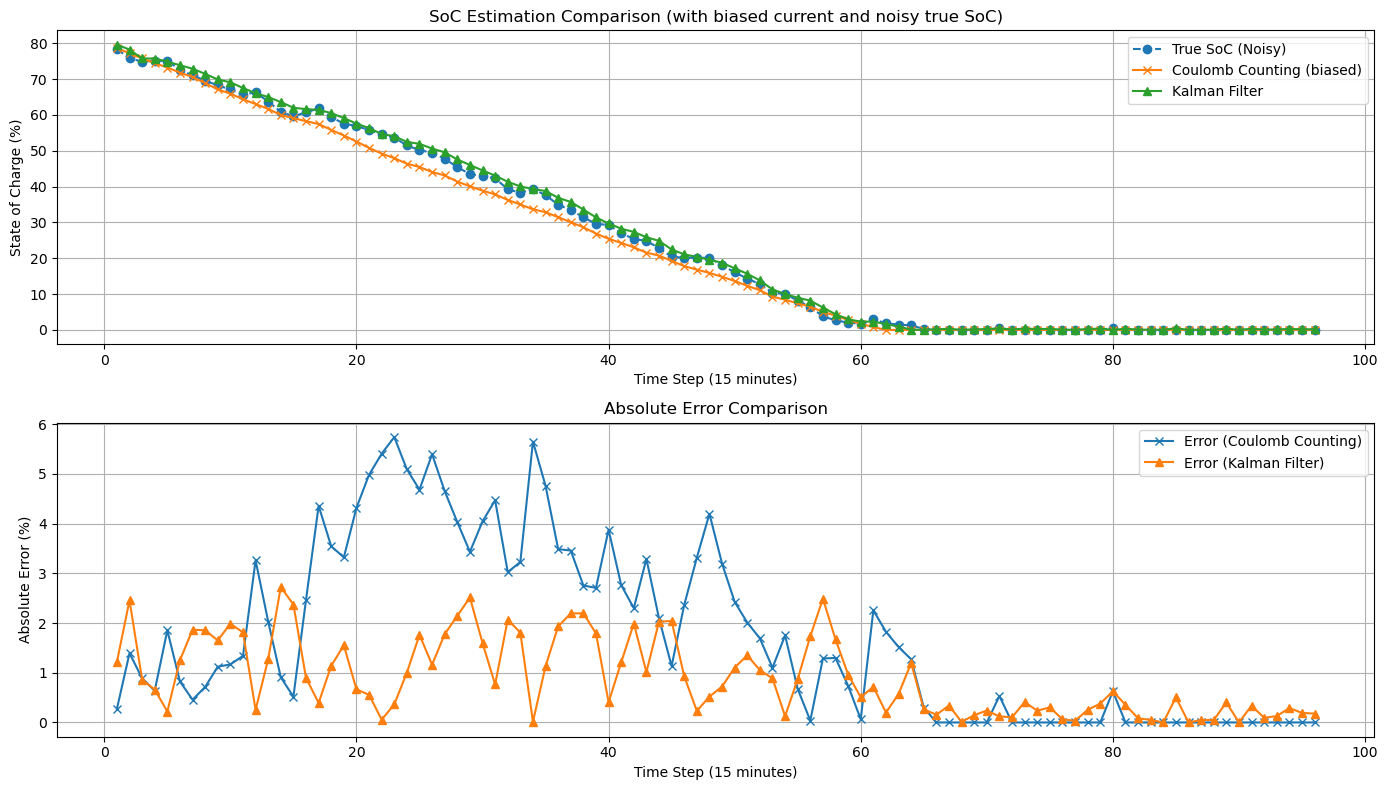

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        # Modified: Steeper OCV curve!
        return 3.0 + 1.0 * soc - 0.2 * soc**2
        # return 3.0 + 0.5 * soc

    def predict(self, current, dt):
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        d_ocv_d_soc = 1.0 - 0.4 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        self.P = (1 - K * d_ocv_d_soc) * self.P


def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,          # 100 Ah
        r_int=0.05,            # Internal resistance
        process_noise=1e-5,    # Increased process noise for better adaptability
        measurement_noise=1e-4 # Slightly increased measurement noise for better adaptation
    )

    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8

    # Current bias to simulate realistic drift
    current_bias = 1.03  # 3% bias in current measurement

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias  # Bias added!

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        
        # Add noise to true SoC
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate voltage measurement
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Small noise

        # Coulomb Counting (biased)
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Kalman prediction and update
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (biased)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison (with biased current and noisy true SoC)")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run
simulate_and_visualize()

Mean Absolute Error (OCV Method): 7.90%


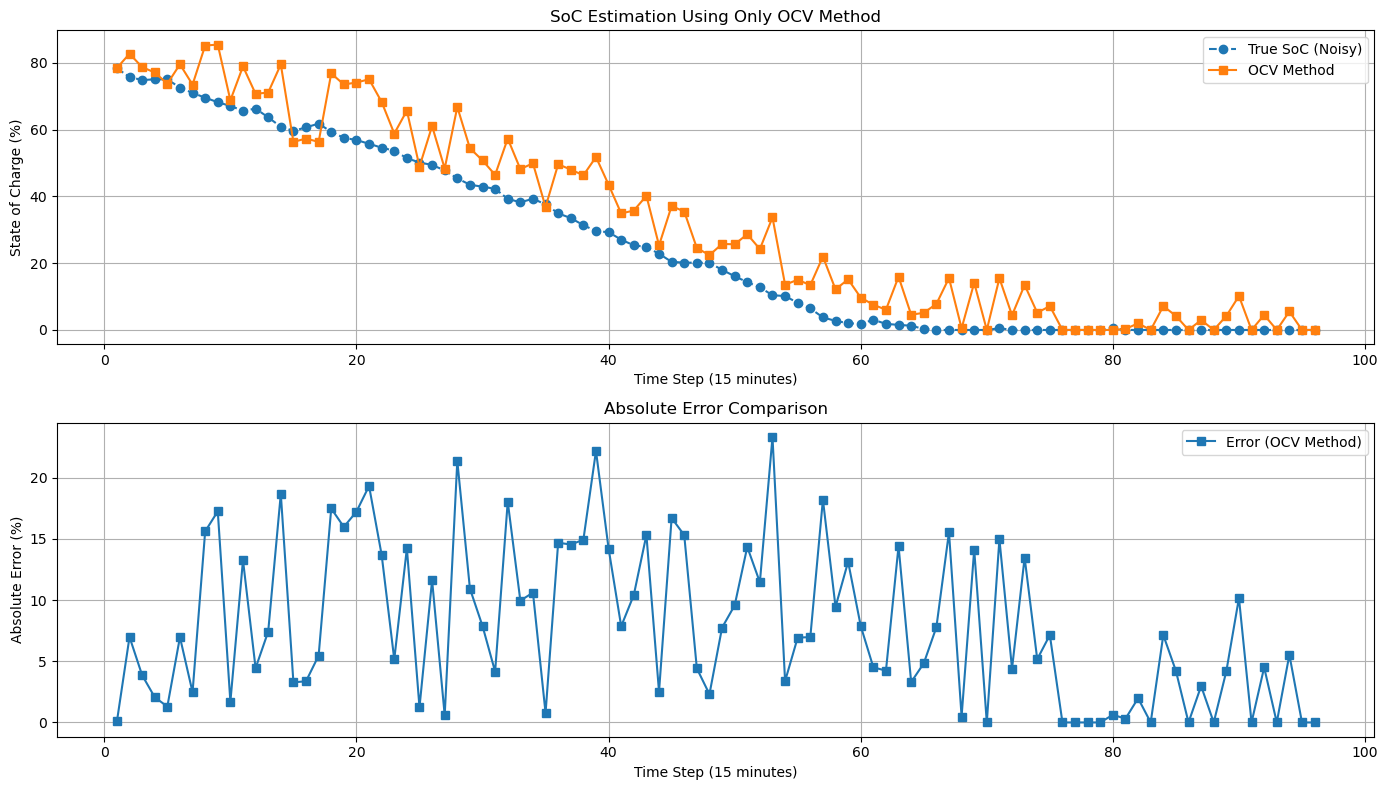

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def ocv_to_soc(ocv):
    """
    Lookup function to convert OCV to SoC using a nonlinear model.
    Inverse of the OCV-SOC relationship: OCV = 3.0 + 1.0 * SoC - 0.2 * SoC^2
    """
    def equation(soc):
        return 3.0 + 1.0 * soc - 0.2 * soc**2 - ocv
    soc_guess = max(0, min(1, (ocv - 3.0) / 1.0))  # Initial guess based on linear approximation
    try:
        soc = fsolve(equation, soc_guess)[0]
    except Exception:
        soc = soc_guess  # Fallback to initial guess if solver fails
    return max(0, min(1, soc))  # Clamp SoC between 0 and 1


def simulate_and_visualize():
    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%
    capacity = 100  # Battery capacity in Ah
    r_int = 0.05  # Internal resistance in Ohms
    measurement_noise = 1e-4

    # Variables to store results
    time_steps = []
    true_socs = []
    ocv_socs = []

    voltage_profile = []  # Simulated voltage profile

    # Low-pass filter for voltage measurements
    alpha_filter = 0.9  # Smoothing factor for voltage filtering
    filtered_voltage = None

    for t in range(len(current_profile)):
        true_current = current_profile[t]

        # Update true SoC
        true_soc -= (true_current * dt) / capacity
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate voltage measurement
        ocv_true = 3.0 + 1.0 * true_soc - 0.2 * true_soc**2  # Nonlinear OCV-SOC relationship
        voltage_measured = ocv_true - true_current * r_int
        voltage_measured += np.random.normal(0, np.sqrt(measurement_noise))  # Add noise

        # Apply low-pass filter to smooth voltage measurements
        if filtered_voltage is None:
            filtered_voltage = voltage_measured
        else:
            filtered_voltage = alpha_filter * filtered_voltage + (1 - alpha_filter) * voltage_measured

        # Estimate SoC using OCV method
        # Compensate for resistive voltage drop to approximate OCV
        estimated_ocv = filtered_voltage + true_current * r_int  # Compensate for load effects
        estimated_soc = ocv_to_soc(estimated_ocv)

        # Save results
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        ocv_socs.append(estimated_soc * 100)

    # Calculate error metrics
    mae_ocv = np.mean(np.abs(np.array(ocv_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (OCV Method): {mae_ocv:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, ocv_socs, label="OCV Method", linestyle="-", marker="s")
    plt.title("SoC Estimation Using Only OCV Method")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_ocv = np.abs(np.array(ocv_socs) - np.array(true_socs))
    plt.plot(time_steps, error_ocv, label="Error (OCV Method)", linestyle="-", marker="s")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run simulation
simulate_and_visualize()

Mean Absolute Error (OCV Method): 8.59%


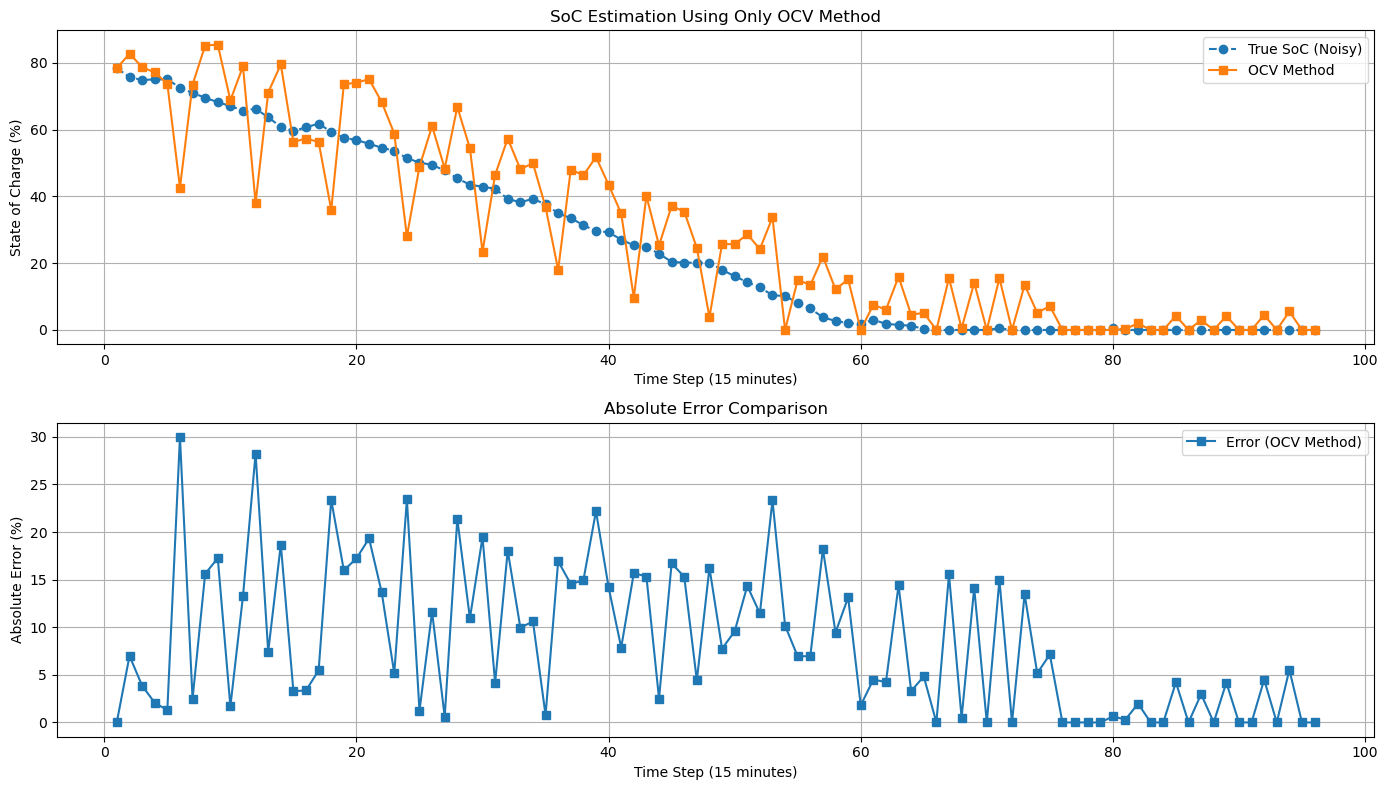

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def ocv_to_soc(ocv, is_charging=False):
    """
    Lookup function to convert OCV to SoC using a nonlinear model.
    Separate OCV-SOC relationships for charging and discharging to account for hysteresis.
    """
    if is_charging:
        # Charging curve: OCV = 3.2 + 0.8 * SoC - 0.15 * SoC^2
        def equation(soc):
            return 3.2 + 0.8 * soc - 0.15 * soc**2 - ocv
    else:
        # Discharging curve: OCV = 3.0 + 1.0 * SoC - 0.2 * SoC^2
        def equation(soc):
            return 3.0 + 1.0 * soc - 0.2 * soc**2 - ocv

    soc_guess = max(0, min(1, (ocv - 3.0) / 1.0))  # Initial guess based on linear approximation
    try:
        soc = fsolve(equation, soc_guess)[0]
    except Exception:
        soc = soc_guess  # Fallback to initial guess if solver fails
    return max(0, min(1, soc))  # Clamp SoC between 0 and 1


def simulate_and_visualize():
    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%
    capacity = 100  # Battery capacity in Ah
    r_int = 0.05  # Internal resistance in Ohms
    measurement_noise = 1e-4

    # Variables to store results
    time_steps = []
    true_socs = []
    ocv_socs = []

    voltage_profile = []  # Simulated voltage profile

    # Low-pass filter for voltage measurements
    alpha_filter = 0.9  # Smoothing factor for voltage filtering
    filtered_voltage = None

    # Rest period logic
    rest_period = False
    rest_counter = 0
    rest_interval = 5  # Rest every 5 time steps

    for t in range(len(current_profile)):
        true_current = current_profile[t]

        # Update true SoC
        true_soc -= (true_current * dt) / capacity
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate rest periods
        if rest_counter >= rest_interval:
            rest_period = True
            rest_counter = 0
        else:
            rest_period = False
            rest_counter += 1

        # Simulate voltage measurement
        ocv_true = 3.0 + 1.0 * true_soc - 0.2 * true_soc**2  # Nonlinear OCV-SOC relationship
        voltage_measured = ocv_true - true_current * r_int
        voltage_measured += np.random.normal(0, np.sqrt(measurement_noise))  # Add noise

        # Apply low-pass filter to smooth voltage measurements
        if filtered_voltage is None:
            filtered_voltage = voltage_measured
        else:
            filtered_voltage = alpha_filter * filtered_voltage + (1 - alpha_filter) * voltage_measured

        # Estimate SoC using OCV method
        if rest_period:
            estimated_ocv = filtered_voltage  # No resistive drop during rest
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging)
        else:
            # Compensate for resistive voltage drop to approximate OCV
            estimated_ocv = filtered_voltage + true_current * r_int
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging)

        # Save results
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        ocv_socs.append(estimated_soc * 100)

    # Calculate error metrics
    mae_ocv = np.mean(np.abs(np.array(ocv_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (OCV Method): {mae_ocv:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, ocv_socs, label="OCV Method", linestyle="-", marker="s")
    plt.title("SoC Estimation Using Only OCV Method")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_ocv = np.abs(np.array(ocv_socs) - np.array(true_socs))
    plt.plot(time_steps, error_ocv, label="Error (OCV Method)", linestyle="-", marker="s")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run simulation
simulate_and_visualize()

Mean Absolute Error (OCV Method): 5.15%


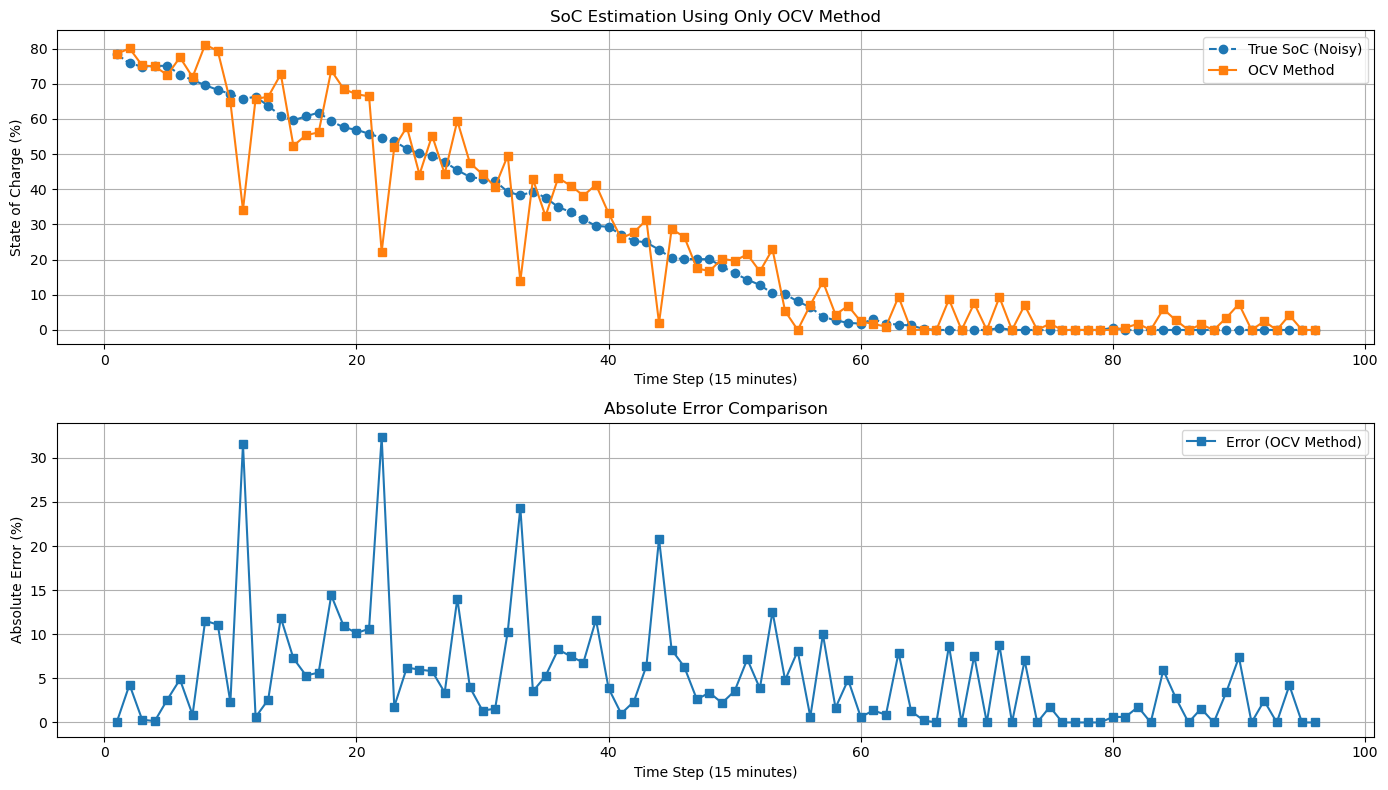

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def ocv_to_soc(ocv, is_charging=False):
    """
    Lookup function to convert OCV to SoC using a nonlinear model.
    Separate OCV-SOC relationships for charging and discharging to account for hysteresis.
    """
    if is_charging:
        # Charging curve: OCV = 3.2 + 0.8 * SoC - 0.15 * SoC^2
        def equation(soc):
            return 3.2 + 0.8 * soc - 0.15 * soc**2 - ocv
    else:
        # Discharging curve: OCV = 3.0 + 1.0 * SoC - 0.2 * SoC^2
        def equation(soc):
            return 3.0 + 1.0 * soc - 0.2 * soc**2 - ocv

    soc_guess = max(0, min(1, (ocv - 3.0) / 1.0))  # Initial guess based on linear approximation
    try:
        soc = fsolve(equation, soc_guess)[0]
    except Exception:
        soc = soc_guess  # Fallback to initial guess if solver fails
    return max(0, min(1, soc))  # Clamp SoC between 0 and 1


class VoltageKalmanFilter:
    """
    Kalman Filter for smoothing voltage measurements.
    """
    def __init__(self, initial_voltage, process_noise, measurement_noise):
        self.voltage_estimate = initial_voltage
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise
        self.error_covariance = 1.0  # Initial error covariance

    def update(self, measured_voltage):
        # Prediction step
        predicted_voltage = self.voltage_estimate
        predicted_error_covariance = self.error_covariance + self.process_noise

        # Update step
        kalman_gain = predicted_error_covariance / (predicted_error_covariance + self.measurement_noise)
        self.voltage_estimate = predicted_voltage + kalman_gain * (measured_voltage - predicted_voltage)
        self.error_covariance = (1 - kalman_gain) * predicted_error_covariance

        return self.voltage_estimate


def simulate_and_visualize():
    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%
    capacity = 100  # Battery capacity in Ah
    r_int = 0.05  # Internal resistance in Ohms
    measurement_noise = 1e-4

    # Variables to store results
    time_steps = []
    true_socs = []
    ocv_socs = []

    voltage_profile = []  # Simulated voltage profile

    # Kalman Filter for voltage measurements
    kf_voltage = VoltageKalmanFilter(initial_voltage=3.6, process_noise=1e-5, measurement_noise=measurement_noise)

    # Rest period logic
    rest_period = False
    rest_counter = 0
    rest_interval = 10  # Rest every 10 time steps
    rest_duration = 2  # Rest for 2 time steps

    for t in range(len(current_profile)):
        true_current = current_profile[t]

        # Update true SoC
        true_soc -= (true_current * dt) / capacity
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate rest periods
        if rest_counter >= rest_interval:
            rest_period = True
            rest_counter = 0
        else:
            rest_period = False
            rest_counter += 1

        # Simulate voltage measurement
        ocv_true = 3.0 + 1.0 * true_soc - 0.2 * true_soc**2  # Nonlinear OCV-SOC relationship
        voltage_measured = ocv_true - true_current * r_int
        voltage_measured += np.random.normal(0, np.sqrt(measurement_noise))  # Add noise

        # Apply Kalman Filter to smooth voltage measurements
        filtered_voltage = kf_voltage.update(voltage_measured)

        # Estimate SoC using OCV method
        if rest_period:
            estimated_ocv = filtered_voltage  # No resistive drop during rest
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging)
        else:
            # Compensate for resistive voltage drop to approximate OCV
            estimated_ocv = filtered_voltage + true_current * r_int
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging)

        # Save results
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        ocv_socs.append(estimated_soc * 100)

    # Calculate error metrics
    mae_ocv = np.mean(np.abs(np.array(ocv_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (OCV Method): {mae_ocv:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, ocv_socs, label="OCV Method", linestyle="-", marker="s")
    plt.title("SoC Estimation Using Only OCV Method")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_ocv = np.abs(np.array(ocv_socs) - np.array(true_socs))
    plt.plot(time_steps, error_ocv, label="Error (OCV Method)", linestyle="-", marker="s")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run simulation
simulate_and_visualize()

Mean Absolute Error (OCV Method): 5.15%


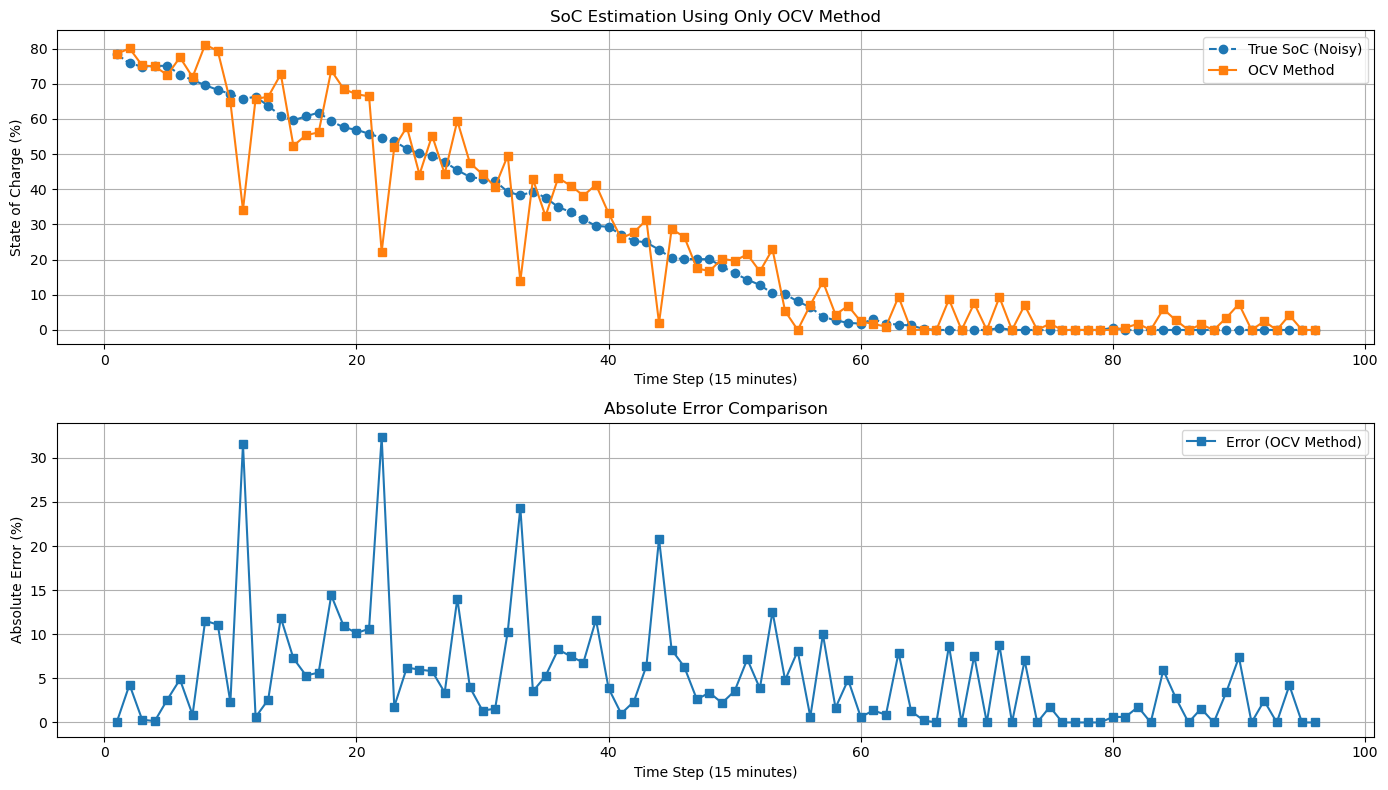

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def ocv_to_soc(ocv, is_charging=False, temperature=25):
    """
    Lookup function to convert OCV to SoC using a nonlinear model.
    Separate OCV-SOC relationships for charging and discharging to account for hysteresis.
    Temperature compensation is included.
    """
    # Adjust OCV-SOC curve based on temperature (example adjustment)
    temp_factor = 1 + 0.001 * (temperature - 25)  # Linear temperature compensation

    if is_charging:
        # Charging curve: OCV = 3.2 + 0.8 * SoC - 0.15 * SoC^2
        def equation(soc):
            return 3.2 * temp_factor + 0.8 * soc - 0.15 * soc**2 - ocv
    else:
        # Discharging curve: OCV = 3.0 + 1.0 * SoC - 0.2 * SoC^2
        def equation(soc):
            return 3.0 * temp_factor + 1.0 * soc - 0.2 * soc**2 - ocv

    soc_guess = max(0, min(1, (ocv - 3.0) / 1.0))  # Initial guess based on linear approximation
    try:
        soc = fsolve(equation, soc_guess)[0]
    except Exception:
        soc = soc_guess  # Fallback to initial guess if solver fails
    return max(0, min(1, soc))  # Clamp SoC between 0 and 1


class VoltageKalmanFilter:
    """
    Kalman Filter for smoothing voltage measurements.
    """
    def __init__(self, initial_voltage, process_noise, measurement_noise):
        self.voltage_estimate = initial_voltage
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise
        self.error_covariance = 1.0  # Initial error covariance

    def update(self, measured_voltage):
        # Prediction step
        predicted_voltage = self.voltage_estimate
        predicted_error_covariance = self.error_covariance + self.process_noise

        # Update step
        kalman_gain = predicted_error_covariance / (predicted_error_covariance + self.measurement_noise)
        self.voltage_estimate = predicted_voltage + kalman_gain * (measured_voltage - predicted_voltage)
        self.error_covariance = (1 - kalman_gain) * predicted_error_covariance

        return self.voltage_estimate


def simulate_and_visualize():
    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%
    capacity = 100  # Battery capacity in Ah
    r_int = 0.05  # Internal resistance in Ohms
    measurement_noise = 1e-4
    temperature = 25  # Simulated temperature in degrees Celsius

    # Variables to store results
    time_steps = []
    true_socs = []
    ocv_socs = []

    voltage_profile = []  # Simulated voltage profile

    # Kalman Filter for voltage measurements
    kf_voltage = VoltageKalmanFilter(initial_voltage=3.6, process_noise=1e-5, measurement_noise=measurement_noise)

    # Rest period logic
    rest_period = False
    rest_counter = 0
    rest_interval = 10  # Rest every 10 time steps
    rest_duration = 2  # Rest for 2 time steps

    for t in range(len(current_profile)):
        true_current = current_profile[t]

        # Update true SoC
        true_soc -= (true_current * dt) / capacity
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate rest periods
        if rest_counter >= rest_interval:
            rest_period = True
            rest_counter = 0
        else:
            rest_period = False
            rest_counter += 1

        # Simulate voltage measurement
        ocv_true = 3.0 + 1.0 * true_soc - 0.2 * true_soc**2  # Nonlinear OCV-SOC relationship
        voltage_measured = ocv_true - true_current * r_int
        voltage_measured += np.random.normal(0, np.sqrt(measurement_noise))  # Add noise

        # Apply Kalman Filter to smooth voltage measurements
        filtered_voltage = kf_voltage.update(voltage_measured)

        # Estimate SoC using OCV method
        if rest_period:
            estimated_ocv = filtered_voltage  # No resistive drop during rest
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging, temperature)
        else:
            # Compensate for resistive voltage drop to approximate OCV
            estimated_ocv = filtered_voltage + true_current * r_int
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging, temperature)

        # Save results
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        ocv_socs.append(estimated_soc * 100)

    # Calculate error metrics
    mae_ocv = np.mean(np.abs(np.array(ocv_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (OCV Method): {mae_ocv:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, ocv_socs, label="OCV Method", linestyle="-", marker="s")
    plt.title("SoC Estimation Using Only OCV Method")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_ocv = np.abs(np.array(ocv_socs) - np.array(true_socs))
    plt.plot(time_steps, error_ocv, label="Error (OCV Method)", linestyle="-", marker="s")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run simulation
simulate_and_visualize()

Mean Absolute Error (OCV Method): 5.15%
Mean Absolute Error (Coulomb Counting): 54.08%


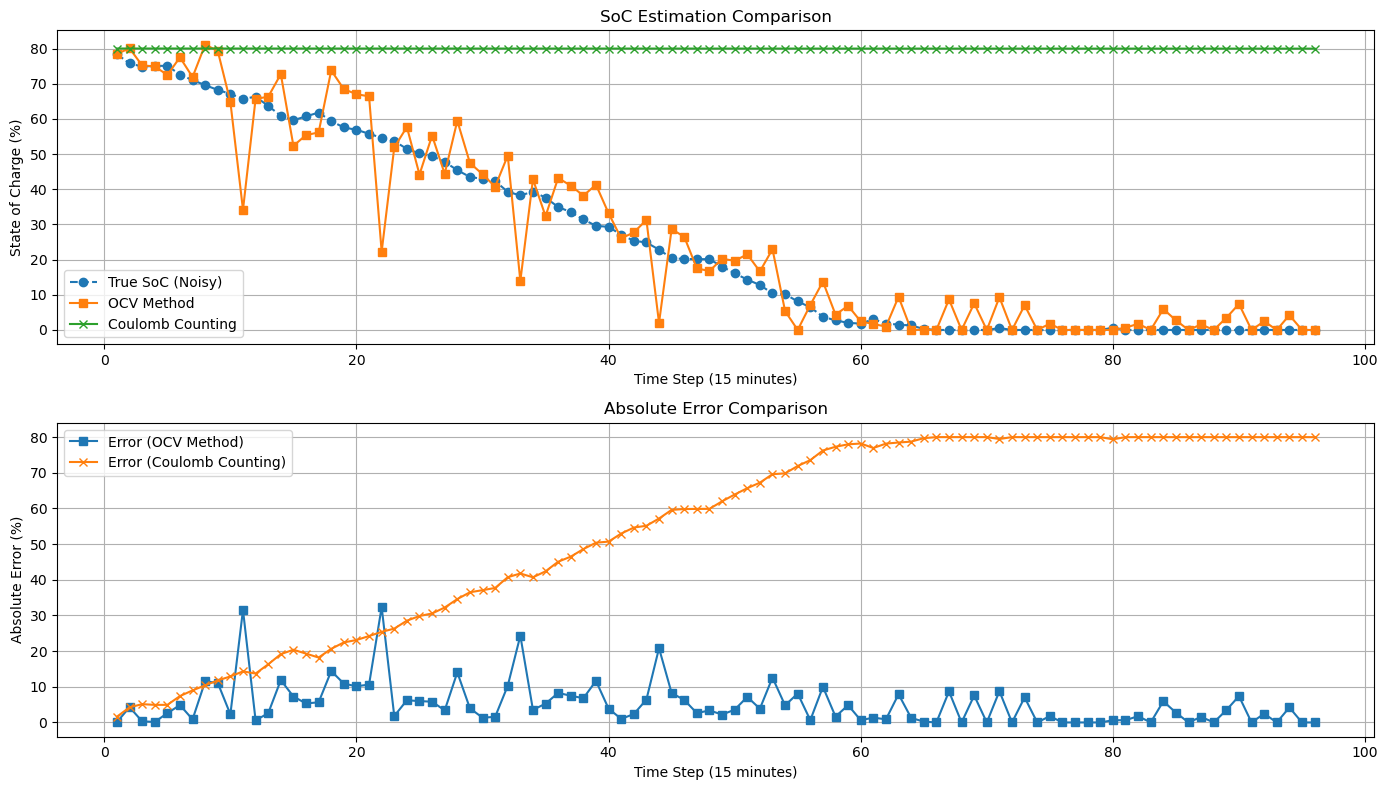

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def ocv_to_soc(ocv, is_charging=False, temperature=25):
    """
    Lookup function to convert OCV to SoC using a nonlinear model.
    Separate OCV-SOC relationships for charging and discharging to account for hysteresis.
    Temperature compensation is included.
    """
    # Adjust OCV-SOC curve based on temperature (example adjustment)
    temp_factor = 1 + 0.001 * (temperature - 25)  # Linear temperature compensation

    if is_charging:
        # Charging curve: OCV = 3.2 + 0.8 * SoC - 0.15 * SoC^2
        def equation(soc):
            return 3.2 * temp_factor + 0.8 * soc - 0.15 * soc**2 - ocv
    else:
        # Discharging curve: OCV = 3.0 + 1.0 * SoC - 0.2 * SoC^2
        def equation(soc):
            return 3.0 * temp_factor + 1.0 * soc - 0.2 * soc**2 - ocv

    soc_guess = max(0, min(1, (ocv - 3.0) / 1.0))  # Initial guess based on linear approximation
    try:
        soc = fsolve(equation, soc_guess)[0]
    except Exception:
        soc = soc_guess  # Fallback to initial guess if solver fails
    return max(0, min(1, soc))  # Clamp SoC between 0 and 1


class VoltageKalmanFilter:
    """
    Kalman Filter for smoothing voltage measurements.
    """
    def __init__(self, initial_voltage, process_noise, measurement_noise):
        self.voltage_estimate = initial_voltage
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise
        self.error_covariance = 1.0  # Initial error covariance

    def update(self, measured_voltage):
        # Prediction step
        predicted_voltage = self.voltage_estimate
        predicted_error_covariance = self.error_covariance + self.process_noise

        # Update step
        kalman_gain = predicted_error_covariance / (predicted_error_covariance + self.measurement_noise)
        self.voltage_estimate = predicted_voltage + kalman_gain * (measured_voltage - predicted_voltage)
        self.error_covariance = (1 - kalman_gain) * predicted_error_covariance

        return self.voltage_estimate


def coulomb_counting(current_profile, capacity, dt, initial_soc):
    """
    Coulomb Counting method to estimate SoC.
    """
    soc_list = [initial_soc]
    soc_prev = initial_soc

    for current in current_profile:
        delta_soc = (current * dt) / (3600 * capacity)  # Current is typically negative during discharge
        soc_new = soc_prev - delta_soc
        soc_new = max(0, min(1, soc_new))  # Clamp SoC between 0 and 1
        soc_list.append(soc_new)
        soc_prev = soc_new

    return soc_list


def simulate_and_visualize():
    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%
    capacity = 100  # Battery capacity in Ah
    r_int = 0.05  # Internal resistance in Ohms
    measurement_noise = 1e-4
    temperature = 25  # Simulated temperature in degrees Celsius

    # Variables to store results
    time_steps = []
    true_socs = []
    ocv_socs = []
    coulomb_socs = []

    voltage_profile = []  # Simulated voltage profile

    # Kalman Filter for voltage measurements
    kf_voltage = VoltageKalmanFilter(initial_voltage=3.6, process_noise=1e-5, measurement_noise=measurement_noise)

    # Rest period logic
    rest_period = False
    rest_counter = 0
    rest_interval = 10  # Rest every 10 time steps
    rest_duration = 2  # Rest for 2 time steps

    # Coulomb Counting initialization
    coulomb_soc = true_soc  # Initial SoC for Coulomb Counting

    for t in range(len(current_profile)):
        true_current = current_profile[t]

        # Update true SoC
        true_soc -= (true_current * dt) / capacity
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate rest periods
        if rest_counter >= rest_interval:
            rest_period = True
            rest_counter = 0
        else:
            rest_period = False
            rest_counter += 1

        # Simulate voltage measurement
        ocv_true = 3.0 + 1.0 * true_soc - 0.2 * true_soc**2  # Nonlinear OCV-SOC relationship
        voltage_measured = ocv_true - true_current * r_int
        voltage_measured += np.random.normal(0, np.sqrt(measurement_noise))  # Add noise

        # Apply Kalman Filter to smooth voltage measurements
        filtered_voltage = kf_voltage.update(voltage_measured)

        # Estimate SoC using OCV method
        if rest_period:
            estimated_ocv = filtered_voltage  # No resistive drop during rest
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging, temperature)
        else:
            # Compensate for resistive voltage drop to approximate OCV
            estimated_ocv = filtered_voltage + true_current * r_int
            is_charging = true_current < 0  # Determine charging/discharging
            estimated_soc = ocv_to_soc(estimated_ocv, is_charging, temperature)

        # Coulomb Counting
        delta_soc = (true_current * dt) / (3600 * capacity)
        coulomb_soc -= delta_soc
        coulomb_soc = max(0, min(1, coulomb_soc))  # Clamp SoC between 0 and 1

        # Save results
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        ocv_socs.append(estimated_soc * 100)
        coulomb_socs.append(coulomb_soc * 100)

    # Calculate error metrics
    mae_ocv = np.mean(np.abs(np.array(ocv_socs) - np.array(true_socs)))
    mae_coulomb = np.mean(np.abs(np.array(coulomb_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (OCV Method): {mae_ocv:.2f}%")
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, ocv_socs, label="OCV Method", linestyle="-", marker="s")
    plt.plot(time_steps, coulomb_socs, label="Coulomb Counting", linestyle="-", marker="x")
    plt.title("SoC Estimation Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_ocv = np.abs(np.array(ocv_socs) - np.array(true_socs))
    error_coulomb = np.abs(np.array(coulomb_socs) - np.array(true_socs))
    plt.plot(time_steps, error_ocv, label="Error (OCV Method)", linestyle="-", marker="s")
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run simulation
simulate_and_visualize()

Mean Absolute Error (Coulomb Counting): 1.17%
Mean Absolute Error (Kalman Filter): 0.91%


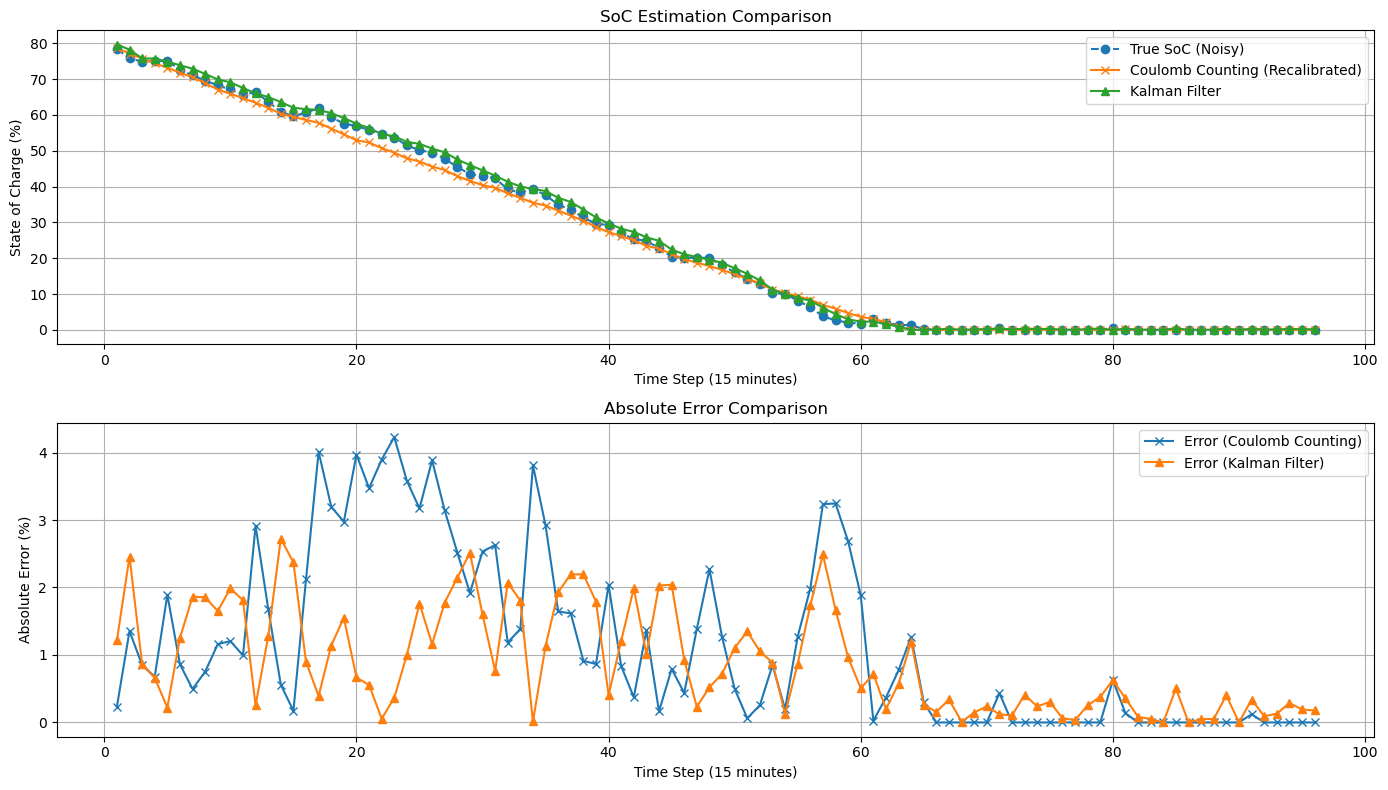

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial  # State estimate
        self.capacity = capacity  # Ah
        self.r_int = r_int  # Internal resistance (Ohm)
        self.P = 0.10  # Estimate error covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance

    def ocv(self, soc):
        return 3.0 + 1.0 * soc - 0.2 * soc**2

    def predict(self, current, dt):
        self.soc = self.soc - (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P = self.P + self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        d_ocv_d_soc = 1.0 - 0.4 * self.soc  # Derivative of OCV w.r.t. SoC
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc = self.soc + K * y
        self.soc = max(0, min(1, self.soc))
        self.P = (1 - K * d_ocv_d_soc) * self.P


def ocv_to_soc(ocv):
    """
    Lookup function to convert OCV to SoC using a nonlinear model.
    Inverse of the OCV-SOC relationship: OCV = 3.0 + 1.0 * SoC - 0.2 * SoC^2
    """
    def equation(soc):
        return 3.0 + 1.0 * soc - 0.2 * soc**2 - ocv
    soc_guess = max(0, min(1, (ocv - 3.0) / 1.0))  # Initial guess based on linear approximation
    try:
        soc = fsolve(equation, soc_guess)[0]
    except Exception:
        soc = soc_guess  # Fallback to initial guess if solver fails
    return max(0, min(1, soc))  # Clamp SoC between 0 and 1


def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,          # 100 Ah
        r_int=0.05,            # Internal resistance
        process_noise=1e-5,    # Increased process noise for better adaptability
        measurement_noise=1e-4 # Slightly increased measurement noise for better adaptation
    )

    # Simulation parameters
    np.random.seed(0)  # Reproducibility
    current_profile = np.random.uniform(3, 7, size=96)  # 96 samples (every 15 minutes)
    dt = 0.25  # Time step (15 minutes)
    true_soc = 0.8  # Start at 80%

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []

    soc_coulomb = 0.8

    # Reduced current bias to 0.5%
    current_bias = 1.03  

    # Rest period logic for Coulomb Counting recalibration
    rest_period = False
    rest_counter = 0
    rest_interval = 10  # Recalibrate every 10 time steps

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias  # Bias added!

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        true_soc += np.random.normal(0, 0.01)  # Small noise added to true SoC
        true_soc = max(0, min(1, true_soc))  # Clamp between 0 and 1

        # Simulate voltage measurement
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))  # Small noise

        # Coulomb Counting (biased)
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Periodic recalibration using OCV
        if t % rest_interval == 0:
            estimated_ocv = voltage_measured + true_current * kf.r_int  # Compensate for resistive drop
            recalibrated_soc = ocv_to_soc(estimated_ocv)
            soc_coulomb = 0.8 * soc_coulomb + 0.2 * recalibrated_soc  # Weighted average

        # Kalman prediction and update
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Calculate error metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (Recalibrated)", linestyle="-", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", linestyle="-", marker="^")
    plt.title("SoC Estimation Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    error_coulomb = np.abs(np.array(coulomb_counting_socs) - np.array(true_socs))
    error_kf = np.abs(np.array(updated_socs) - np.array(true_socs))
    plt.plot(time_steps, error_coulomb, label="Error (Coulomb Counting)", linestyle="-", marker="x")
    plt.plot(time_steps, error_kf, label="Error (Kalman Filter)", linestyle="-", marker="^")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run
simulate_and_visualize()

Mean Absolute Error (Coulomb Counting): 1.15%
Mean Absolute Error (Kalman Filter): 0.91%
Mean Absolute Error (OCV Method): 4.29%


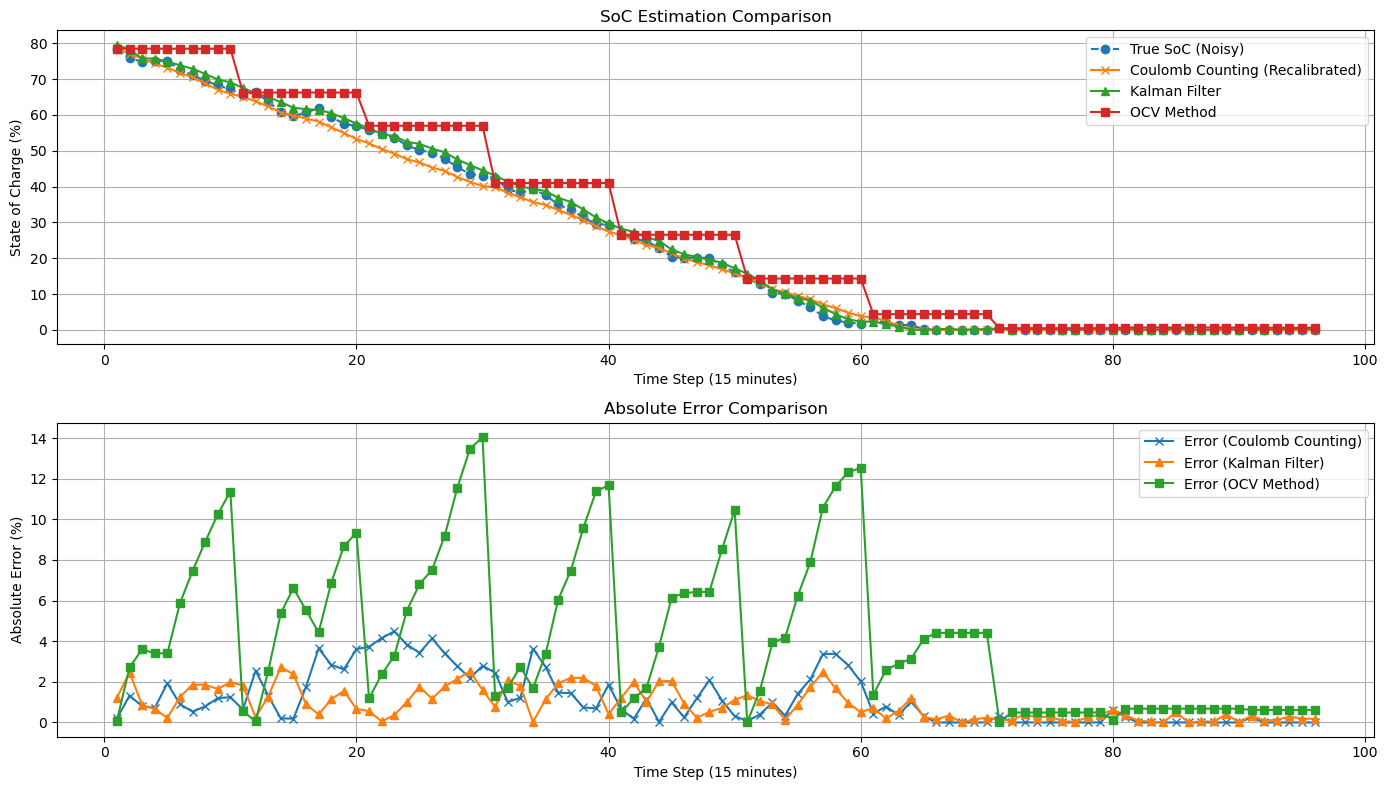

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

class KalmanFilterSoC:
    def __init__(self, soc_initial, capacity, r_int, process_noise, measurement_noise):
        self.soc = soc_initial
        self.capacity = capacity
        self.r_int = r_int
        self.P = 0.10
        self.Q = process_noise
        self.R = measurement_noise

    def ocv(self, soc):
        return 3.0 + 1.0 * soc - 0.2 * soc**2

    def predict(self, current, dt):
        self.soc -= (current * dt) / self.capacity
        self.soc = max(0, min(1, self.soc))
        self.P += self.Q

    def update(self, voltage_measured, current):
        v_pred = self.ocv(self.soc) - current * self.r_int
        y = voltage_measured - v_pred
        d_ocv_d_soc = 1.0 - 0.4 * self.soc
        S = self.P * d_ocv_d_soc**2 + self.R
        K = self.P * d_ocv_d_soc / S
        self.soc += K * y
        self.soc = max(0, min(1, self.soc))
        self.P *= (1 - K * d_ocv_d_soc)

def ocv_to_soc(ocv):
    def equation(soc):
        return 3.0 + 1.0 * soc - 0.2 * soc**2 - ocv
    soc_guess = max(0, min(1, (ocv - 3.0) / 1.0))
    try:
        soc = fsolve(equation, soc_guess)[0]
    except Exception:
        soc = soc_guess
    return max(0, min(1, soc))

def simulate_and_visualize():
    kf = KalmanFilterSoC(
        soc_initial=0.8,
        capacity=100,
        r_int=0.05,
        process_noise=1e-5,
        measurement_noise=1e-4
    )

    np.random.seed(0)
    current_profile = np.random.uniform(3, 7, size=96)
    dt = 0.25
    true_soc = 0.8

    time_steps = []
    true_socs = []
    predicted_socs = []
    updated_socs = []
    coulomb_counting_socs = []
    ocv_socs = []

    soc_coulomb = 0.8
    current_bias = 1.03
    rest_interval = 10

    for t in range(len(current_profile)):
        true_current = current_profile[t]
        measured_current = true_current * current_bias

        # Update true SoC
        true_soc -= (true_current * dt) / kf.capacity
        true_soc += np.random.normal(0, 0.01)
        true_soc = max(0, min(1, true_soc))

        # Simulate voltage measurement
        ocv_true = kf.ocv(true_soc)
        voltage_measured = ocv_true - true_current * kf.r_int
        voltage_measured += np.random.normal(0, np.sqrt(kf.R))

        # Coulomb Counting
        soc_coulomb -= (measured_current * dt) / kf.capacity
        soc_coulomb = max(0, min(1, soc_coulomb))

        # Recalibration using OCV (Adaptive weighting)
        if t % rest_interval == 0:
            estimated_ocv = voltage_measured + true_current * kf.r_int
            recalibrated_soc = ocv_to_soc(estimated_ocv)

            # Adaptive weight based on difference
            error_estimate = abs(recalibrated_soc - soc_coulomb)
            if error_estimate < 0.02:
                alpha = 0.4
            elif error_estimate > 0.05:
                alpha = 0.1
            else:
                alpha = 0.2

            soc_coulomb = (1 - alpha) * soc_coulomb + alpha * recalibrated_soc
            ocv_soc = recalibrated_soc
        else:
            ocv_soc = ocv_socs[-1] if ocv_socs else 0.8

        ocv_socs.append(ocv_soc)

        # Kalman Filter
        kf.predict(current=measured_current, dt=dt)
        predicted_soc = kf.soc
        kf.update(voltage_measured=voltage_measured, current=measured_current)
        updated_soc = kf.soc

        # Save results
        time_steps.append(t + 1)
        true_socs.append(true_soc * 100)
        predicted_socs.append(predicted_soc * 100)
        updated_socs.append(updated_soc * 100)
        coulomb_counting_socs.append(soc_coulomb * 100)

    # Error Metrics
    mae_coulomb = np.mean(np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)))
    mae_updated = np.mean(np.abs(np.array(updated_socs) - np.array(true_socs)))
    mae_ocv = np.mean(np.abs(np.array(ocv_socs) * 100 - np.array(true_socs)))

    print(f"Mean Absolute Error (Coulomb Counting): {mae_coulomb:.2f}%")
    print(f"Mean Absolute Error (Kalman Filter): {mae_updated:.2f}%")
    print(f"Mean Absolute Error (OCV Method): {mae_ocv:.2f}%")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_socs, label="True SoC (Noisy)", linestyle="--", marker="o")
    plt.plot(time_steps, coulomb_counting_socs, label="Coulomb Counting (Recalibrated)", marker="x")
    plt.plot(time_steps, updated_socs, label="Kalman Filter", marker="^")
    plt.plot(time_steps, np.array(ocv_socs) * 100, label="OCV Method", marker="s")
    plt.title("SoC Estimation Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("State of Charge (%)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(time_steps, np.abs(np.array(coulomb_counting_socs) - np.array(true_socs)), label="Error (Coulomb Counting)", marker="x")
    plt.plot(time_steps, np.abs(np.array(updated_socs) - np.array(true_socs)), label="Error (Kalman Filter)", marker="^")
    plt.plot(time_steps, np.abs(np.array(ocv_socs) * 100 - np.array(true_socs)), label="Error (OCV Method)", marker="s")
    plt.title("Absolute Error Comparison")
    plt.xlabel("Time Step (15 minutes)")
    plt.ylabel("Absolute Error (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run simulation
simulate_and_visualize()
